In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ✅ STEP 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from collections import Counter
from sklearn.utils import class_weight

In [3]:
# ✅ STEP 2: Set Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
from google.colab import files
uploaded = files.upload()

Saving PlantVillage.zip to PlantVillage.zip


In [5]:
zip_path = "/content/PlantVillage.zip"
extract_path = "/content/PlantVillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipping complete.")


✅ Unzipping complete.


In [6]:
# ✅ STEP 4: Load Dataset from Extracted Folder
dataset_path = os.path.join(extract_path, "PlantVillage")
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("\n✅ Classes:", class_names)
print("✅ Number of batches:", len(dataset))


Found 2152 files belonging to 3 classes.

✅ Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
✅ Number of batches: 68


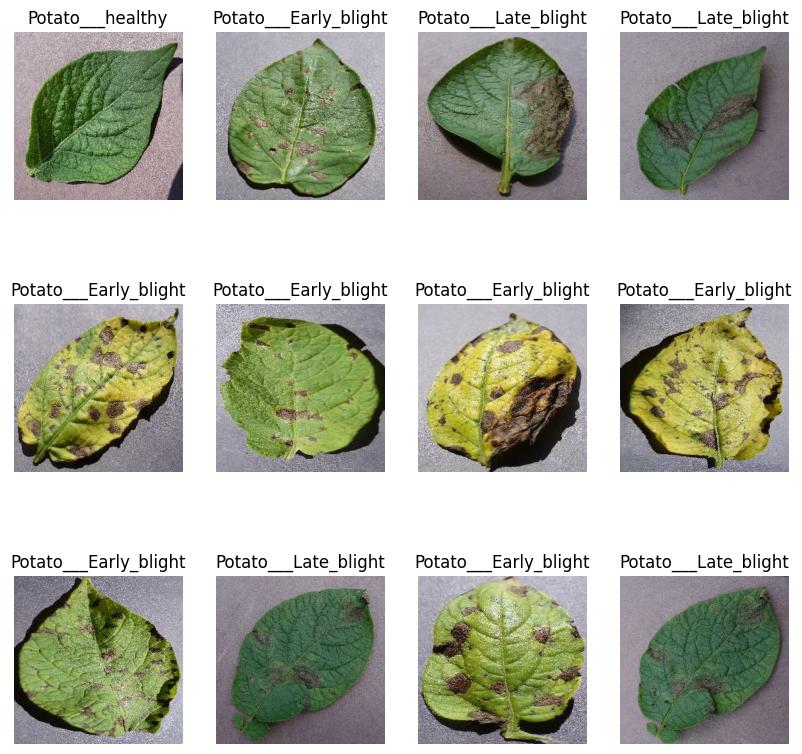

In [7]:
# ✅ STEP 5: Visualize Samples
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
# ✅ STEP 6: Split Dataset
train_size = 0.8
val_size = 0.1
test_size = 0.1

def split_dataset(ds, train_size=0.8, val_size=0.1, test_size=0.1):
    ds_size = len(ds)
    train = ds.take(int(train_size * ds_size))
    val = ds.skip(int(train_size * ds_size)).take(int(val_size * ds_size))
    test = ds.skip(int(train_size * ds_size + val_size * ds_size))
    return train, val, test

train_ds, val_ds, test_ds = split_dataset(dataset)

print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("Test batches:", len(test_ds))

Train batches: 54
Validation batches: 6
Test batches: 7


In [9]:
from sklearn.utils import class_weight
import numpy as np

y_labels = []
for _, labels in dataset:
    y_labels.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)

class_weights_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("\n✅ Class Weights:", class_weights_dict)



✅ Class Weights: {0: 0.7173333333333334, 1: 0.7173333333333334, 2: 4.719298245614035}


In [10]:
+# ✅ STEP 8: Prefetching for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# ✅ STEP 9: Preprocessing & Augmentation
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [12]:
# ✅ STEP 10: Build the Model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict,  # ✅ This is the correct one
    verbose=1
)



Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.3759 - loss: 1.4932 - val_accuracy: 0.0938 - val_loss: 1.1141
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.4799 - loss: 0.9491 - val_accuracy: 0.7448 - val_loss: 0.4688
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - accuracy: 0.8211 - loss: 0.4079 - val_accuracy: 0.8542 - val_loss: 0.3699
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.8421 - loss: 0.2996 - val_accuracy: 0.9010 - val_loss: 0.3719
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.8661 - loss: 0.2722 - val_accuracy: 0.9271 - val_loss: 0.1707
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9072 - loss: 0.2031 - val_accuracy: 0.9115 - val_loss: 0.1826
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9162 - loss: 0.1771 - val_accuracy: 0.8958 - val_loss: 0.3658
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9159 - loss: 0.1703 - val_accuracy: 0.9375 - v

In [15]:
# STEP 12: Evaluate the trained model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 827ms/step - accuracy: 0.9795 - loss: 0.0643

✅ Test Accuracy: 0.9700
✅ Test Loss: 0.0914


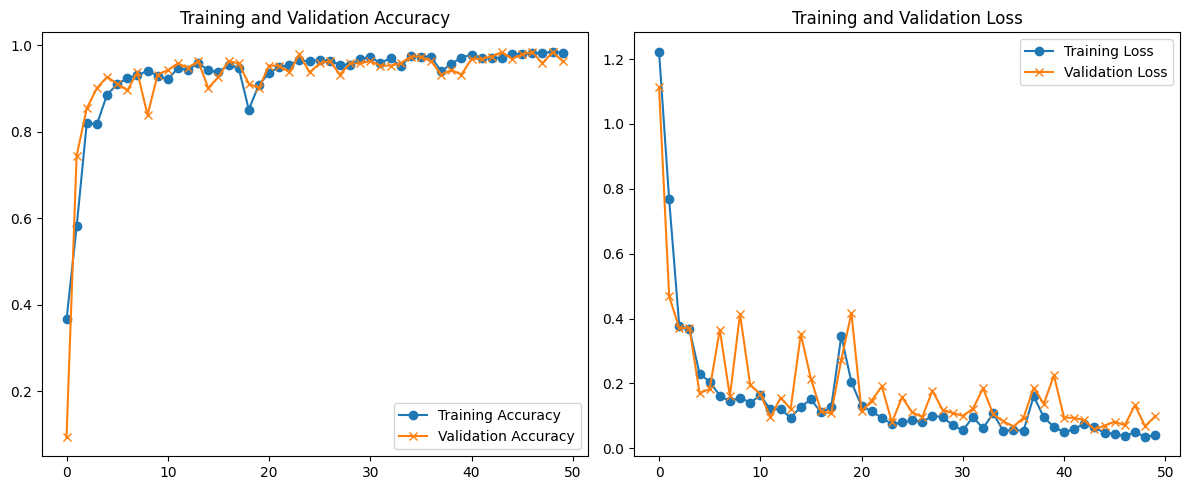

In [16]:
# STEP 13: Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [17]:
import os

# STEP 14: Save model with versioning
model_dir = "/content/models"
os.makedirs(model_dir, exist_ok=True)

# Get existing versions
existing_versions = [
    int(f.split('.')[0]) for f in os.listdir(model_dir)
    if f.endswith(".keras") and f.split('.')[0].isdigit()
]

# Next version number
model_version = max(existing_versions, default=0) + 1

# Save the model
model_path = f"{model_dir}/{model_version}.keras"
model.save(model_path)

print(f"✅ Model saved as {model_path}")


✅ Model saved as /content/models/1.keras


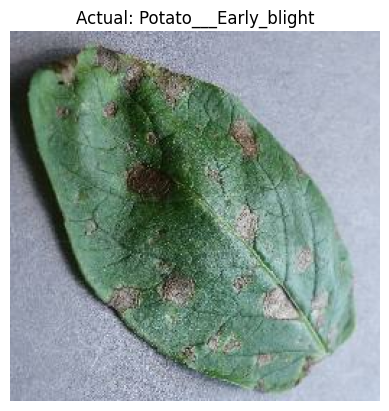

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
🔍 Predicted: Potato___Early_blight (99.9800033569336%)


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get class names
class_names = dataset.class_names

# Convert test_ds to a list of batches (only once, small dataset)
test_batches = list(test_ds)

# Randomly select one batch
images_batch, labels_batch = random.choice(test_batches)

# Randomly select one image from the batch
i = random.randint(0, len(images_batch) - 1)
image = images_batch[i].numpy().astype("uint8")
label = labels_batch[i].numpy()

# Show image
plt.imshow(image)
plt.title(f"Actual: {class_names[label]}")
plt.axis("off")
plt.show()

# Predict
img_array = tf.expand_dims(images_batch[i], 0)
predictions = model.predict(img_array)
predicted_label = np.argmax(predictions[0])
confidence = round(100 * np.max(predictions[0]), 2)

print(f"🔍 Predicted: {class_names[predicted_label]} ({confidence}%)")



In [48]:
from google.colab import files
files.download('/content/models/1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>